## Introduction.
**What is SETI**
- SETI stands for Search for Extraterrestrial Intelligence is a collective term for scientific searches for intelligent extraterrestrial life, for example, monitoring electromagnetic radiation for signs of transmissions from civilizations on other planets

- The SETI Institute is a not-for-profit research organization incorporated in 1984 whose mission is to explore, understand, and explain the origin and nature of life in the universe, and to apply the knowledge gained to inspire and guide present and future generations. It aims for discovery and for sharing knowledge as scientific ambassadors to the public, the press, and the government. SETI stands for the "search for extraterrestrial intelligence".

- Source: [SETI institute](https://en.wikipedia.org/wiki/SETI_Institute)

Different classes in the Dataset.

- BrightPixel

- NarrowBand

- NarrowBandDRD

- Noise

- Square Pulsed NarrowBand

- Squibble

- Single Square Pulsed NarrowBand

In [1]:
# importing necessary library
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [11]:
data_dir = '../../Data/seti-data/primary_small'

In [12]:
os.listdir(data_dir)

['test', 'train', 'valid']

In [13]:
train_data_dir = data_dir + '/train'
valid_data_dir = data_dir +'/valid'
test_data_dir = data_dir + '/test'

In [14]:
os.listdir(train_data_dir)

['brightpixel',
 'narrowband',
 'narrowbanddrd',
 'noise',
 'squarepulsednarrowband',
 'squiggle',
 'squigglesquarepulsednarrowband']

## Importing dataset using pyTorch
use `ImageFolder` class from `torchvision`

In [15]:
train_ds = ImageFolder(train_data_dir,tt.Compose([tt.Resize(32),
                                                  tt.ToTensor()]))
val_ds = ImageFolder(valid_data_dir,tt.Compose([tt.Resize(32),
                                                  tt.ToTensor()]))

In [16]:
print(len(train_ds))
print(len(val_ds))

5600
700


In [17]:
train_ds[0][0].shape

torch.Size([3, 32, 42])

In [18]:
for cls in os.listdir(train_data_dir):
  print(cls,':',len(os.listdir(train_data_dir+'/'+cls)))

brightpixel : 800
narrowband : 800
narrowbanddrd : 800
noise : 800
squarepulsednarrowband : 800
squiggle : 800
squigglesquarepulsednarrowband : 800


In [19]:
import cv2
import random

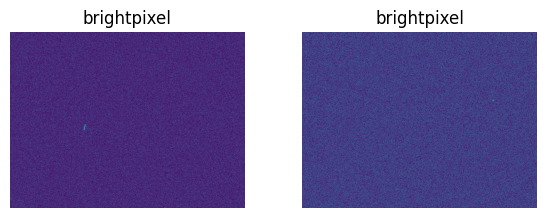

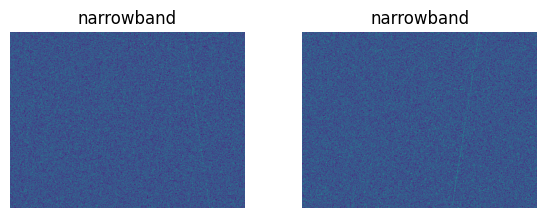

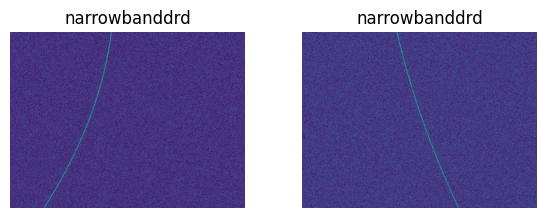

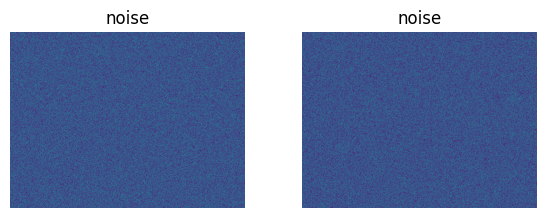

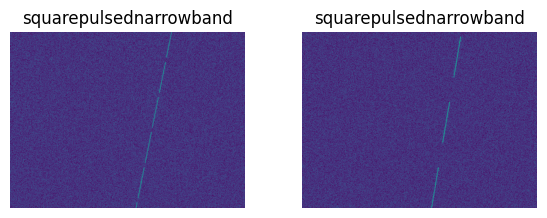

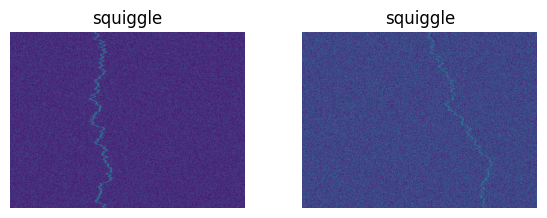

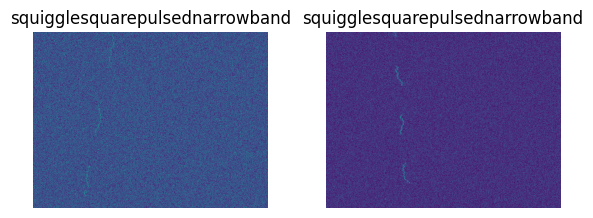

In [22]:

classes = ["brightpixel",
            "narrowband",
            "narrowbanddrd",
            "noise",
            "squarepulsednarrowband",
            "squiggle",
            "squigglesquarepulsednarrowband"]
num_images = 2
for _class in classes:
    # start off by observing images
    path = os.path.join(train_data_dir, _class)
    image_files = os.listdir(path)
    random_images = random.sample(range(0, len(image_files)-1), num_images)
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(6, 8), squeeze=False)
    fig.tight_layout()
    for l in range(1):
        for m in range(num_images):
            axes[l][m].imshow(cv2.imread(os.path.join(path, image_files[random_images[m]]), 0))
            axes[l][m].axis("off")
            axes[l][m].set_title(_class)

In [23]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')

Label:  brightpixel (0)


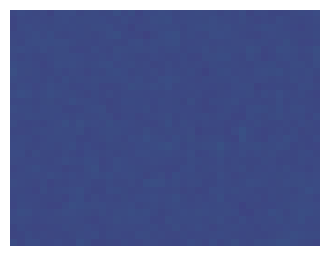

In [24]:
show_example(*train_ds[0])

Label:  narrowband (1)


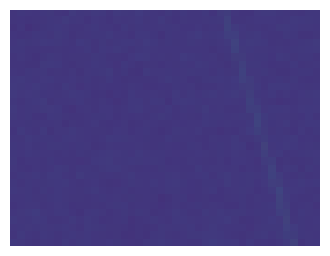

In [25]:
show_example(*train_ds[1500])

In [26]:
batch_size= 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

In [29]:

def show_batch(dl):
  """
    Display a batch of images and their corresponding labels.

    Args:
        dl (torch.utils.data.DataLoader): DataLoader object containing the batch of images and labels.

    Returns:
        None

    """
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0),cmap='gray')
    break

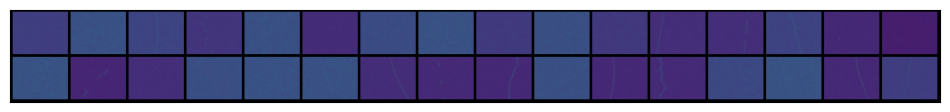

In [30]:
show_batch(train_dl)

### GPU Utilities

In [31]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
device = get_default_device()
device

device(type='cuda')

In [33]:
train_dl =DeviceDataLoader(train_dl,device)
val_dl =DeviceDataLoader(val_dl,device)

In [34]:
class ImageClassificationBase(nn.Module):
  """
    Base class for image classification models.

    Provides common training and validation methods.

    Attributes:
        None

    Methods:
        training_step(batch):
            Perform a single training step.

        validation_step(batch):
            Perform a single validation step.

        validation_epoch_end(outputs):
            Perform validation epoch end calculations.

        epoch_end(epoch, result):
            Print the epoch summary.

    """
  def training_step(self, batch):
    images, labels = batch
    # labels=labels.unsqueeze(1)
    # print(labels.shape)
    # print(labels)
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
      epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
  """
    Calculate the accuracy of predicted outputs.

    Args:
        outputs (torch.Tensor): Predicted outputs from the model.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        torch.Tensor: The accuracy value.

    """
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [35]:
@torch.no_grad()
def evaluate(model, val_loader):
  """
  Evaluate the model on the validation set.

  Args:
      model (nn.Module): The model to evaluate.
      val_loader (DataLoader): DataLoader for the validation set.

  Returns:
      dict: Dictionary containing epoch-level validation loss and accuracy.

  """
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  """
    Get the learning rate of the optimizer.

    Args:
        optimizer (Optimizer): The optimizer.

    Returns:
        float: The learning rate.

    """
  for param_group in optimizer.param_groups:
      return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  """
    Fit the model using the One Cycle Policy.

    Args:
        epochs (int): Number of epochs to train.
        max_lr (float): Maximum learning rate.
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        weight_decay (float, optional): Strength of weight decay regularization. Defaults to 0.
        grad_clip (float, optional): Maximum gradient norm value for gradient clipping. Defaults to None.
        opt_func (Optimizer, optional): Optimizer to use. Defaults to torch.optim.SGD.

    Returns:
        None

  """
  torch.cuda.empty_cache()
  history = []

  # Set up cutom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                              steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
      # Training Phase
      model.train()
      train_losses = []
      lrs = []
      for batch in train_loader:
          loss = model.training_step(batch)
          train_losses.append(loss)
          loss.backward()

          # Gradient clipping
          if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)

          optimizer.step()
          optimizer.zero_grad()

          # Record & update learning rate
          lrs.append(get_lr(optimizer))
          sched.step()

      # Validation phase
      result = evaluate(model, val_loader)
      result['train_loss'] = torch.stack(train_losses).mean().item()
      result['lrs'] = lrs
      model.epoch_end(epoch, result)
      history.append(result)
  return history

In [36]:
def conv_block(in_channels, out_channels, pool=False):
  """
    Create a convolutional block consisting of convolution, batch normalization, and ReLU activation.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        pool (bool, optional): Whether to include max pooling layer. Defaults to False.

    Returns:
        nn.Sequential: Sequential module containing the convolutional block.

    """
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # input 32 x 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64) # 32 x 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 32 x 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), # 32 x 128 x 16 x 16
                                  conv_block(128, 128)) # 32 x 128 x 16 x 16

        self.conv3 = conv_block(128, 256, pool=True) # 32 x 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 32 x 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), # 32 x 512 x 4 x 4
                                  conv_block(512, 512)) # 32 x 512 x 4 x 4

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 32 x 512 x 1 x 1
                                        nn.Flatten(), # 32 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [37]:
model = to_device(ResNet9(3,len(train_ds.classes)),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [38]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [39]:
torch.cuda.empty_cache()
for batch in train_dl:
  img, label = batch
  print(img.shape)
  print(img.device)
  preds = model(img)
  print(preds.shape)
  break

torch.Size([32, 3, 32, 42])
cuda:0
torch.Size([32, 7])


In [40]:
for batch in val_dl:
  img, label = batch
  print(img.shape)
  print(img.device)
  preds = model(img)
  print(preds.shape)
  break

torch.Size([32, 3, 32, 42])
cuda:0
torch.Size([32, 7])


In [41]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.9475371837615967, 'val_acc': 0.14204545319080353}]

## Training

In [42]:
epochs = 8
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [43]:
import time
train_time = time.time()
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)
print(f"Train time: {time.time()-train_time}")

Epoch [0], train_loss: 1.9802, val_loss: 1.6072, val_acc: 0.4296
Epoch [1], train_loss: 1.4520, val_loss: 1.1272, val_acc: 0.5913
Epoch [2], train_loss: 1.0307, val_loss: 0.9457, val_acc: 0.6412
Epoch [3], train_loss: 0.7921, val_loss: 1.4814, val_acc: 0.4635
Epoch [4], train_loss: 0.7207, val_loss: 0.8608, val_acc: 0.7017
Epoch [5], train_loss: 0.6191, val_loss: 0.6501, val_acc: 0.7366
Epoch [6], train_loss: 0.5302, val_loss: 0.5873, val_acc: 0.7823
Epoch [7], train_loss: 0.4658, val_loss: 0.5760, val_acc: 0.7855
Train time: 333.233683347702


In [49]:
plt.rcParams['figure.figsize'] = (6, 4)
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

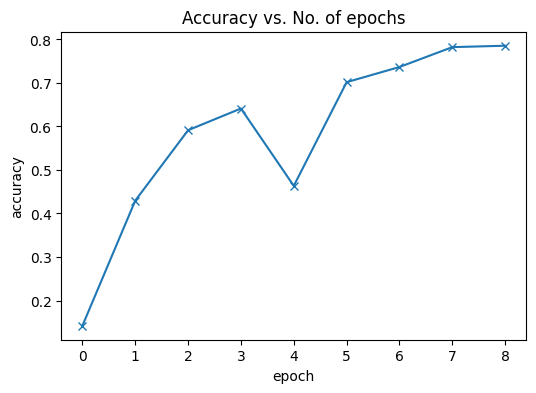

In [50]:
plot_accuracies(history)

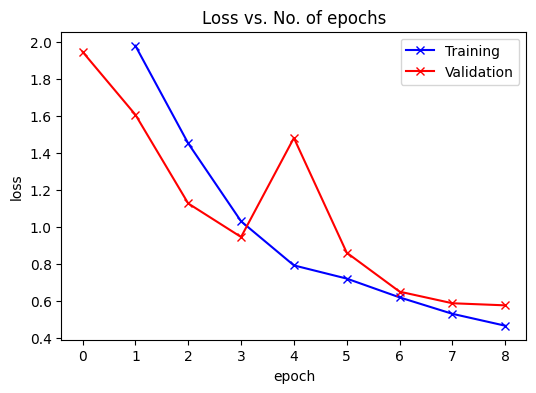

In [51]:
plot_losses(history)


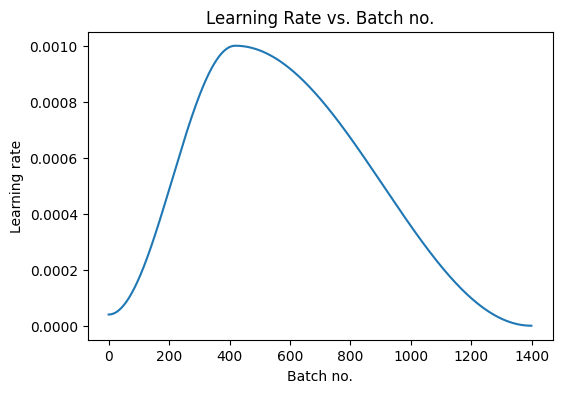

In [52]:
plot_lrs(history)

## Testing

In [62]:
test_ds = ImageFolder(test_data_dir,tt.Compose([tt.Resize(32),
                                                  tt.ToTensor()]))
test_dl = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [63]:
# Put the model in evaluation mode
model.eval()

# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Iterate through the test data and make predictions
for inputs, labels in test_dl:
    # inputs, labels = inputs.to(device), labels.to(device)
    
    # Forward pass
    outputs = model(inputs)
    
    # Convert outputs to probabilities using softmax
    probs = torch.softmax(outputs, dim=1)
    
    # Append true labels and predicted probabilities
    true_labels.extend(labels.cpu().numpy())
    predicted_probs.extend(probs.detach().cpu().numpy())

# Convert true labels to numpy array
true_labels = np.array(true_labels)

# Get predicted labels by selecting the class with the highest probability
predicted_labels = np.argmax(predicted_probs, axis=1)

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

def plot_multiclass_classification_results(true_labels, predicted_labels, predicted_probs, class_names):
    """
    Generate various plots for multiclass classification results.
    Args:
        true_labels (array-like): True labels.
        predicted_labels (array-like): Predicted labels.
        predicted_probs (array-like): Predicted probabilities.
        class_names (list): List of class names.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Histogram of Class Distribution
    sns.countplot(x=true_labels, palette='Set2', ax=axes[0, 0])
    axes[0, 0].set_title('Class Distribution')
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_xticklabels(class_names, rotation=45)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names, ax=axes[0, 1])
    axes[0, 1].set_title('Confusion Matrix')
    axes[0, 1].set_xlabel('Predicted Label')
    axes[0, 1].set_ylabel('True Label')

    # Precision-Recall Curve
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve((true_labels == i).astype(int), (predicted_labels == i).astype(int))
        axes[1, 0].plot(recall, precision, marker='.', label=f'Class {class_names[i]}')
    axes[1, 0].legend()

    # ROC Curve
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve((true_labels == i).astype(int), (predicted_labels == i).astype(int) )
        roc_auc = auc(fpr, tpr)
        axes[1, 1].plot(fpr, tpr, marker='.', label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()



In [58]:
import warnings

warnings.filterwarnings("ignore")

In [60]:
classes

['brightpixel',
 'narrowband',
 'narrowbanddrd',
 'noise',
 'squarepulsednarrowband',
 'squiggle',
 'squigglesquarepulsednarrowband']

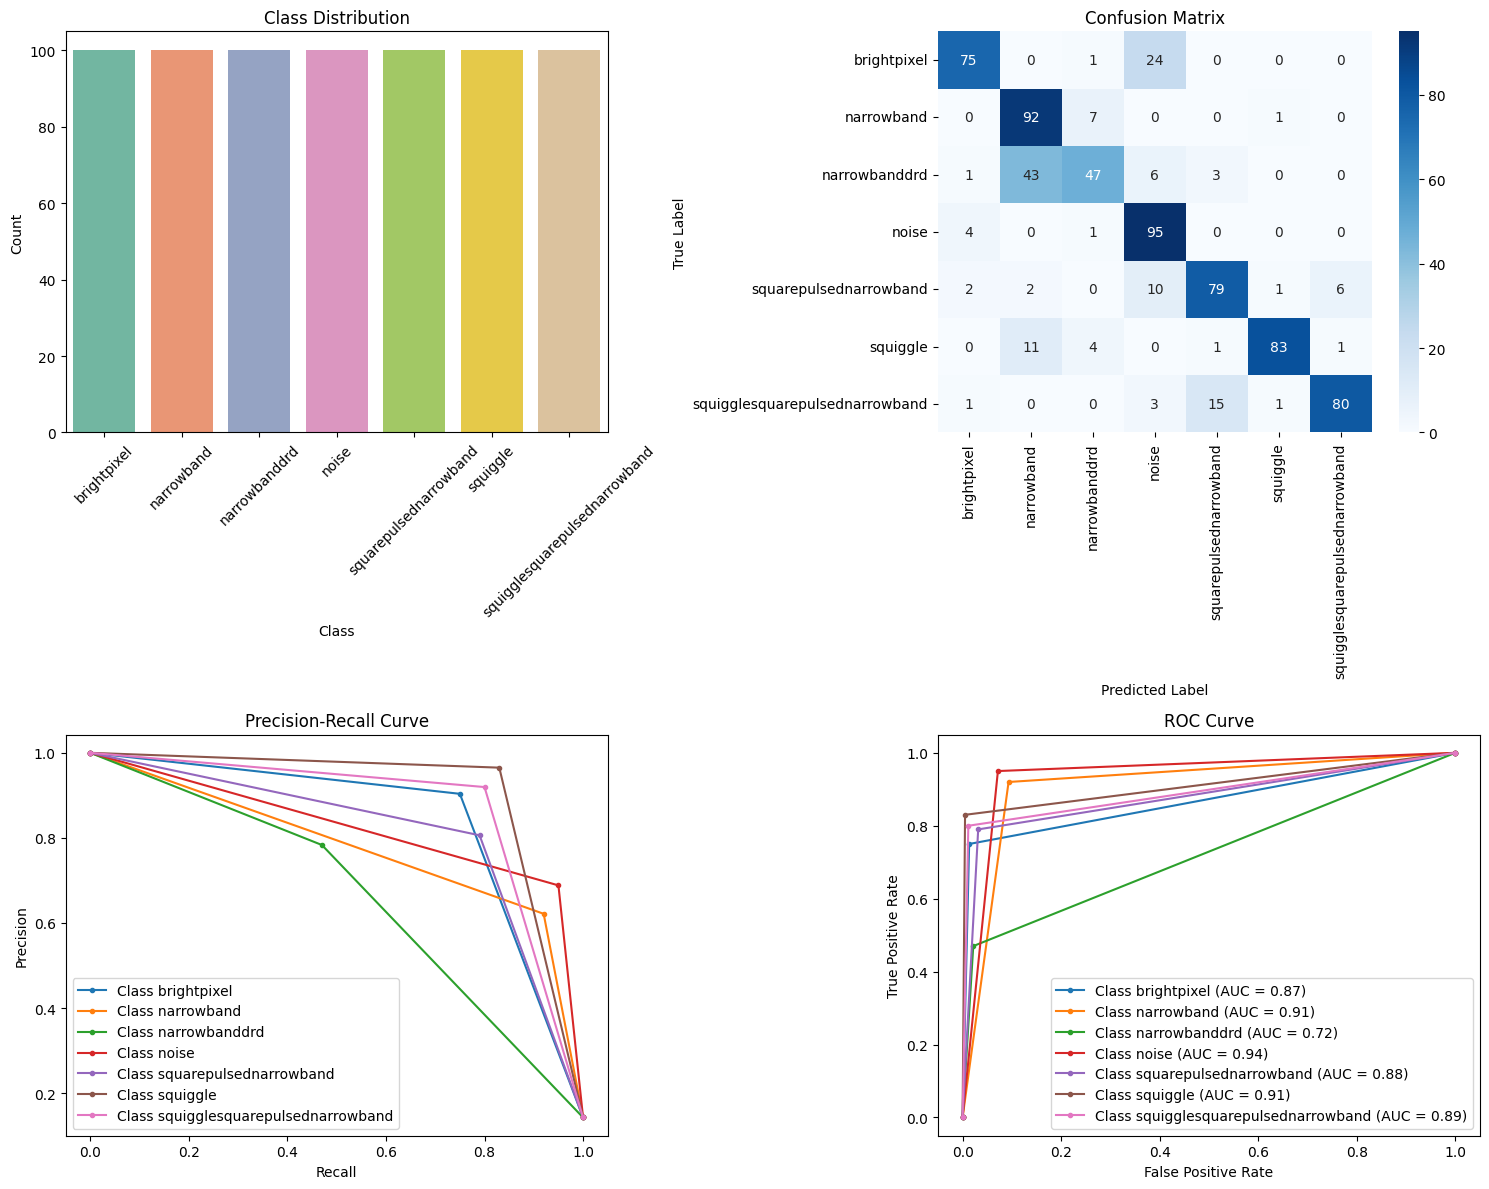

In [65]:
plot_multiclass_classification_results(true_labels, predicted_labels, predicted_probs, classes)

In [66]:
setiNet = model

In [67]:
torch.save(setiNet, 'setiNet.pth')